In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm

In [270]:
import numpy as np
import matplotlib.pyplot as plt

## variable declarations
a = 2  # Altura del dominio
b = 6  # Ancho del dominio (mayor que 2 * a)
nx = 41  # Número de puntos en el eje x
ny = 41  # Número de puntos en el eje y
nt = 10  # Número de pasos de tiempo
nit = 50  # Número de iteraciones para Poisson
c = 1  # Velocidad de propagación
dx = b / (nx - 1)  # Paso en x
dy = a / (ny - 1)  # Paso en y
x = np.linspace(0, b, nx)  # Coordenadas en x (de 0 a b)
y = np.linspace(0, a, ny)  # Coordenadas en y (de 0 a a)
X, Y = np.meshgrid(x, y)  # Rejilla 2D

## physical variables
rho = 1
nu = 0.1
F = 1
dt = .001
u0 = 1
 # Velocidad constante de entrada

# initial conditions
u = np.zeros((ny, nx))
un = np.zeros((ny, nx))

v = np.zeros((ny, nx))
vn = np.zeros((ny, nx))

p = np.ones((ny, nx))
pn = np.ones((ny, nx))

b = np.zeros((ny, nx))

# Define the obstacle radius and center
obstacle_radius = a / 25  # Radio del obstáculo

d = 2  # Distancia deseada del obstáculo al borde de entrada en el eje x
obstacle_center_x = int(d / dx)  # Convertir la distancia a índice de la malla
d_y = 1 # Distancia deseada del obstáculo al borde inferior en el eje y
obstacle_center_y = int(d_y / dy)  # Convertir la distancia a índice de la malla

# obstacle_center_x = nx // 2  # Centro en el eje x
# obstacle_center_y = ny // 2  # Centro en el eje y

# Create a mask for the obstacle (distance from the center of the obstacle)
distance = np.sqrt((X - x[obstacle_center_x])**2 + (Y - y[obstacle_center_y])**2)
mask_obstacle = distance <= obstacle_radius

def build_up_b(rho, dt, dx, dy, u, v):
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                                      (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                            2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                                 (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                            ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    # Periodic BC Pressure @ x = 2
    b[1:-1, -1] = (rho * (1 / dt * ((u[1:-1, 0] - u[1:-1,-2]) / (2 * dx) +
                                    (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                          ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                          2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                               (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) -
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))

    # Periodic BC Pressure @ x = 0
    b[1:-1, 0] = (rho * (1 / dt * ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) +
                                   (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                         ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                         2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                              (v[1:-1, 1] - v[1:-1, -1]) / (2 * dx))-
                         ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))
    
    return b

def pressure_poisson_periodic(p, dx, dy):
    pn = np.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])

        # Periodic BC Pressure @ x = 2
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # Periodic BC Pressure @ x = 0
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # Wall boundary conditions, pressure
        p[:,-1] = p[:,-2]
        p[-1, :] =p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :] = p[1, :]  # dp/dy = 0 at y = 0
        p[:,0] = 0

    return p


udiff = 1
stepcount = 0

while udiff > .001:
    un = u.copy()
    vn = v.copy()

    # Aquí calculamos el campo 'b' y la presión
    b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p, dx, dy)
    

    # Actualizar las velocidades utilizando la fórmula de Navier-Stokes
    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                     F * dt)

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * rho * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    # Aplicar la condición de no deslizamiento al obstáculo (máscara)
    u[mask_obstacle] = 0
    v[mask_obstacle] = 0

    # Condiciones periódicas en los bordes
    # u[1:-1, -1] = u[1:-1, -2]  # No flujo en la salida (gradiente cero)
    # v[1:-1, -1] = v[1:-1, -2]  # No flujo en la salida (gradiente cero)

    # Wall BC: u,v = 0 @ y = 0,2
    u[0, :] = u0
    u[-1, :] = u0
    u[:,0] = u0
    u[:,-1] = u[:,-2]
    v[0, :] = 0
    v[:,0 ] = 0
    v[-1, :] = 0
    v[:,-1] = 0
    
    # Cálculo de la diferencia relativa de las velocidades
    udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
    stepcount += 1


In [194]:
# Calcular la vorticidad
vorticity = np.zeros_like(u)
vorticity[1:-1, 1:-1] = ( (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx) - 
                          (u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) )


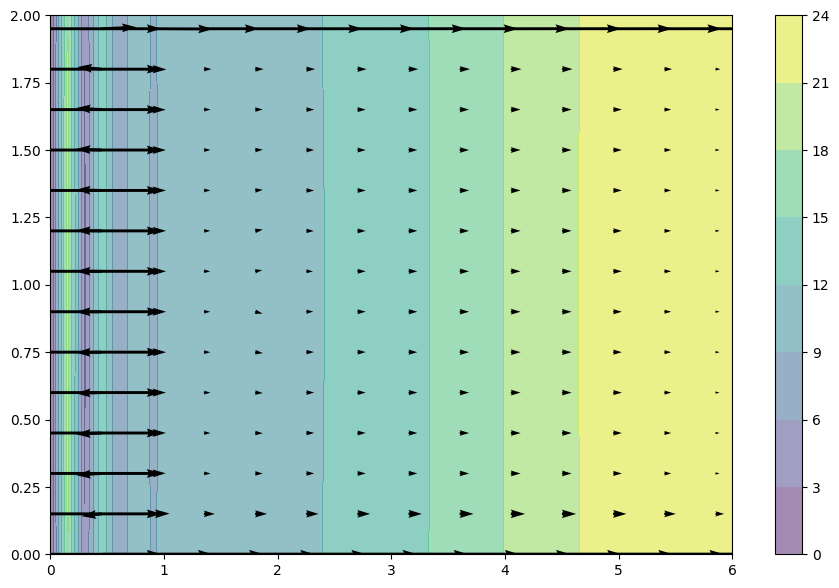

In [271]:
fig = plt.figure(figsize = (11,7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
plt.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3])

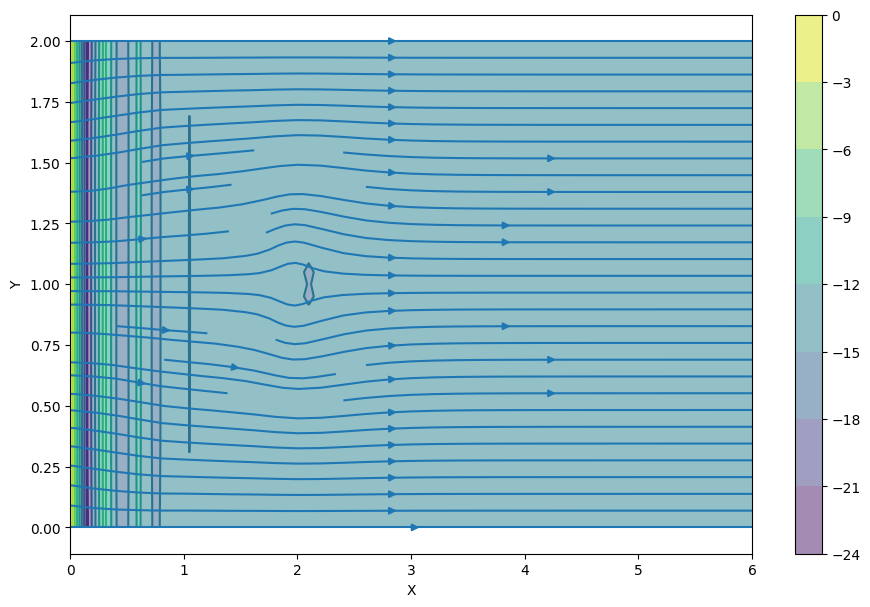

In [267]:
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()
plt.contour(X, Y, p, cmap=cm.viridis)
plt.streamplot(X, Y, u, v)
plt.xlabel('X')
plt.ylabel('Y');